# <font color='red'>**Transformer implementation**</font>

<font color='blue'>**Load the data**</font>

In [1]:
"""
!pip install -q tfds-nightly
!pip install streamlit --user
!pip install tensorflow --user
!pip install tensorflow_datasets --user
"""

     |████████████████████████████████| 4.3 MB 7.7 MB/s 
     |████████████████████████████████| 98 kB 7.5 MB/s 


In [1]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9,.?! ]+', '', text)
    text = text.split()
    text = " ".join(text)
    return text

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [40]:
import pickle
data = pickle.load(open('datasets/data','rb'))

In [41]:
data.isna().sum()

enc_gen    0
enc_inp    0
dec_inp    0
dec_gen    0
dtype: int64

In [42]:
data

,enc_gen,enc_inp,dec_inp,dec_gen
0,f,can we make this quick roxanne korrine and an...,well i thought we would start with pronunciati...,m
1,m,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part ...,f
2,f,not the hacking and gagging and spitting part ...,okay then how bout we try out some french cuis...,m
3,f,you are asking me out that is so cute what is...,forget it,m
4,f,no no it is my fault we did not have a proper...,cameron,m
...,...,...,...,...
221611,gender,your orders mr vereker,i am to take the sikali with the main column t...,gender
221612,gender,i am to take the sikali with the main column t...,lord chelmsford seems to want me to stay back ...,gender
221613,gender,lord chelmsford seems to want me to stay back ...,i think chelmsford wants a good man on the bor...,gender
221614,gender,well i assure you sir i have no desire to crea...,and i assure you you do not in fact i would be...,gender


In [43]:
#Preprocessing the Data dataframe
data['enc_inp'] = data['enc_inp'].apply(preprocess)
data['dec_inp'] = data['dec_inp'].apply(preprocess)
data['enc_gen'] = data['enc_gen'].apply(preprocess)
data['dec_gen'] = data['dec_gen'].apply(preprocess)
data.head()

,enc_gen,enc_inp,dec_inp,dec_gen
0,f,can we make this quick roxanne korrine and and...,well i thought we would start with pronunciati...,m
1,m,well i thought we would start with pronunciati...,not the hacking and gagging and spitting part ...,f
2,f,not the hacking and gagging and spitting part ...,okay then how bout we try out some french cuis...,m
3,f,you are asking me out that is so cute what is ...,forget it,m
4,f,no no it is my fault we did not have a proper ...,cameron,m


In [44]:
import tensorflow_datasets as tfds

In [45]:
data.dec_inp.values

array(['well i thought we would start with pronunciation if that is okay with you',
       'not the hacking and gagging and spitting part please',
       'okay then how bout we try out some french cuisine saturday night',
       ...,
       'i think chelmsford wants a good man on the border why he fears a flanking attack and requires a steady commander in reserve',
       'and i assure you you do not in fact i would be obliged for your best advice what have your scouts seen',
       'so far only their scouts but we have had reports of a small impi farther north over there'],
      dtype=object)

In [46]:
# Tokenization

#https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data.enc_inp.values + data.dec_inp.values , target_vocab_size=2**13) # 2^13 ~ 8000 words

In [47]:
# Functions used later as in "train_examples.map(tf_encode)"



# encode function is use by tf_encode

# Add [CLS] and [SEP] and encode tokens for pt and en
MAX_LENGTH = 40

def encode(lang1, lang2):

  enc_token = []
  dec_token = []

  for (i,j) in zip(lang1, lang2):

    lang1 = [tokenizer.vocab_size] + tokenizer.encode(i) + [tokenizer.vocab_size+1]

    lang2 = [tokenizer.vocab_size] + tokenizer.encode(j) + [tokenizer.vocab_size+1]
    
    if len(lang1) <= MAX_LENGTH and len(lang2) <= MAX_LENGTH: 
      enc_token.append(lang1)
      dec_token.append(lang2)
    
  enc_token = tf.keras.preprocessing.sequence.pad_sequences(enc_token, maxlen = MAX_LENGTH, padding='post')

  dec_token = tf.keras.preprocessing.sequence.pad_sequences(dec_token, maxlen = MAX_LENGTH, padding='post')

  
  return enc_token, dec_token

In [48]:
#Splitting data into train and validation 
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [15]:
#pickle.dump((train, validation),open('/content/drive/MyDrive/Case Study2/data_split.pkl','wb'))

In [49]:
train_enc, train_dec = encode(train.enc_inp, train.dec_inp)

In [50]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets

BUFFER_SIZE = 20000
BATCH_SIZE = 512


dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_enc,
        'dec_inputs': train_dec[:, :-1]
    },
    {
        'outputs': train_dec[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [51]:
#train.enc_inp = train.enc_inp.apply(strip_gender)
#validation.enc_inp = validation.enc_inp.apply(strip_gender)
next(iter(dataset))

({'inputs': <tf.Tensor: shape=(512, 40), dtype=int32, numpy=
  array([[8261, 3940, 8037, ...,    0,    0,    0],
         [8261,   12, 1392, ...,    0,    0,    0],
         [8261,  494,   70, ...,    0,    0,    0],
         ...,
         [8261,   10,   37, ...,    0,    0,    0],
         [8261,   11, 3963, ...,    0,    0,    0],
         [8261,   35,    1, ...,    0,    0,    0]])>,
  'dec_inputs': <tf.Tensor: shape=(512, 39), dtype=int32, numpy=
  array([[8261,   90, 3555, ...,    0,    0,    0],
         [8261, 7689, 6269, ...,    0,    0,    0],
         [8261, 4114, 3132, ...,    0,    0,    0],
         ...,
         [8261, 2354, 8126, ...,    0,    0,    0],
         [8261,    1,   52, ...,    0,    0,    0],
         [8261,  101,    2, ...,    0,    0,    0]])>},
 {'outputs': <tf.Tensor: shape=(512, 39), dtype=int32, numpy=
  array([[  90, 3555,  114, ...,    0,    0,    0],
         [7689, 6269,   10, ...,    0,    0,    0],
         [4114, 3132,  699, ...,    0,    0,    0

## <font color='blue'>**Positional Encoder**</font>

In [52]:
import tensorflow as tf
import tensorflow.keras as keras
from  tensorflow.keras.layers import LSTM, Embedding, Dense, BatchNormalization

In [53]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [54]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


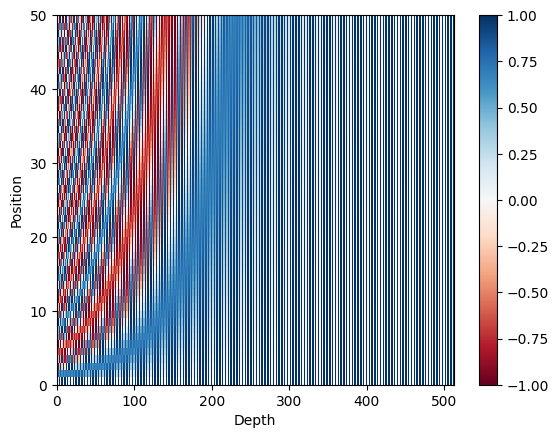

In [55]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

<font color='blue'>**Masking**</font>

In [56]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [57]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [58]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [59]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [60]:
def scaled_dot_product_attention(query, key, value, mask):
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask zero out padding tokens.
  if mask is not None:
    logits += (mask * -1e9)

  attention_weights = tf.nn.softmax(logits, axis=-1)

  return tf.matmul(attention_weights, value)

In [61]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    outputs = self.dense(concat_attention)

    return outputs

In [62]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [63]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [64]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [65]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [66]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [67]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

      #1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [119]:

# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 512
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 40



In [120]:
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1
# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [98]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [88]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [89]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [121]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return float(tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2))

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  accuracy = tf.metrics.SparseCategoricalAccuracy()(y_true, y_pred)
  return accuracy


In [122]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model 

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 256)            2775552   ['inputs[0][0]',              
                                                                     'enc_padding_mask[0

In [123]:
model.fit(dataset, epochs=40)

Epoch 1/5
315/315 [==============================] - 4604s 14s/step - loss: 1.5353 - accuracy: 0.0559
Epoch 2/5
315/315 [==============================] - 4029s 13s/step - loss: 1.3112 - accuracy: 0.0711
Epoch 3/5
315/315 [==============================] - 3784s 12s/step - loss: 1.2463 - accuracy: 0.0748
Epoch 4/5
315/315 [==============================] - 3767s 12s/step - loss: 1.2041 - accuracy: 0.0773
Epoch 5/5
315/315 [==============================] - 3601s 11s/step - loss: 1.1702 - accuracy: 0.0794


In [124]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [125]:
def evaluate(sentence):
  sentence = preprocess(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [142]:
pickle.dump(tokenizer, open("./Streamlit_app/tokenizer.pkl", "wb"))

In [143]:
model.save_weights('./Streamlit_app/checkpoints/my_checkpoint')

In [127]:
output = predict('I love you')

Input: I love you
Output: i do not know i do not know i do not know i do not want to be a woman i love you


In [128]:
output = predict('go to heaven')

Input: go to heaven
Output: i do not know i do not know i do not know i do not know i do not know i do not know i do not know what i mean


In [129]:
output = predict('go to school with mom')

Input: go to school with mom
Output: i do not know i do not know i do not know i do not know i do not know i do not know i do not know what i mean


In [130]:
output = predict('good night dear')

Input: good night dear
Output: you are a good friend of mine i am a good man and i am a good man and i am a good night


In [108]:
output = predict('would you like a dinner with me')

Input: would you like a dinner with me
Output: i am not going to marry you


In [109]:
output = predict('what do you mean')

Input: what do you mean
Output: i do not know i am not going to have to do it with you


In [133]:
output = predict('how are you')

Input: how are you
Output: i am not a cop i am not a cop i am not a little bit i am not a little bit of a little while i am going to be in the house


In [111]:
output = predict('idiot')

Input: idiot
Output: i do not know i am not a good man i am not a good man i am not a good man i am not sure it is a good idea of a good time


In [131]:
predict('hi')
predict('how are you?')

Input: hi
Output: hi i am sorry i am sorry i am sorry i am sorry i am not a little bit i am gonna be in the middle of the night
Input: how are you?
Output: i am not a fool i am not a cop i am not a cop i am not a fool i am a little tired of a little more of yours


'i am not a fool i am not a cop i am not a cop i am not a fool i am a little tired of a little more of yours'

In [112]:
# feed the model with its previous output
sentence = 'go to school with mom'
for _ in range(5):
  sentence = predict(sentence)
  print('')

Input: go to school with mom
Output: i do not know i am not going to be a good man i am not going to be a good man and i will be in a while

Input: i do not know i am not going to be a good man i am not going to be a good man and i will be in a while
Output: i do not know i am not going to be a good man i am not going to be a good man and i will be right back

Input: i do not know i am not going to be a good man i am not going to be a good man and i will be right back
Output: i will be right back

Input: i will be right back
Output: i am not going to be a good night

Input: i am not going to be a good night
Output: i am not going to be a good one of your friends are not you a good man you are going to be a good night



In [117]:
# feed the model with its previous output
sentence = 'get out !'
for _ in range(5):
  sentence = predict(sentence)
  print('')

Input: get out !
Output: i am not going to be here i am not going to be here i am not going to be here i am not going to be here i am not going to be here with you

Input: i am not going to be here i am not going to be here i am not going to be here i am not going to be here i am not going to be here with you
Output: i am not going to be a good one of my friends are not you going to be here i am not going to be here i am not going to be here with you

Input: i am not going to be a good one of my friends are not you going to be here i am not going to be here i am not going to be here with you
Output: i am not going to be a good man i am not going to be a good man i am not going to be a good night

Input: i am not going to be a good man i am not going to be a good man i am not going to be a good night
Output: i am not going to be a good man i am not going to be a good man i am not going to do anything i am not going to be a good night

Input: i am not going to be a good man i am not goin

# video of deploying the model on streamlit
https://www.youtube.com/watch?v=Pzztrsnq-mw